In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [69]:
df_id = pd.read_csv("../input/train_identity.csv")
df_trans = pd.read_csv("../input/train_transaction.csv")


In [70]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [71]:
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [73]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


In [74]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


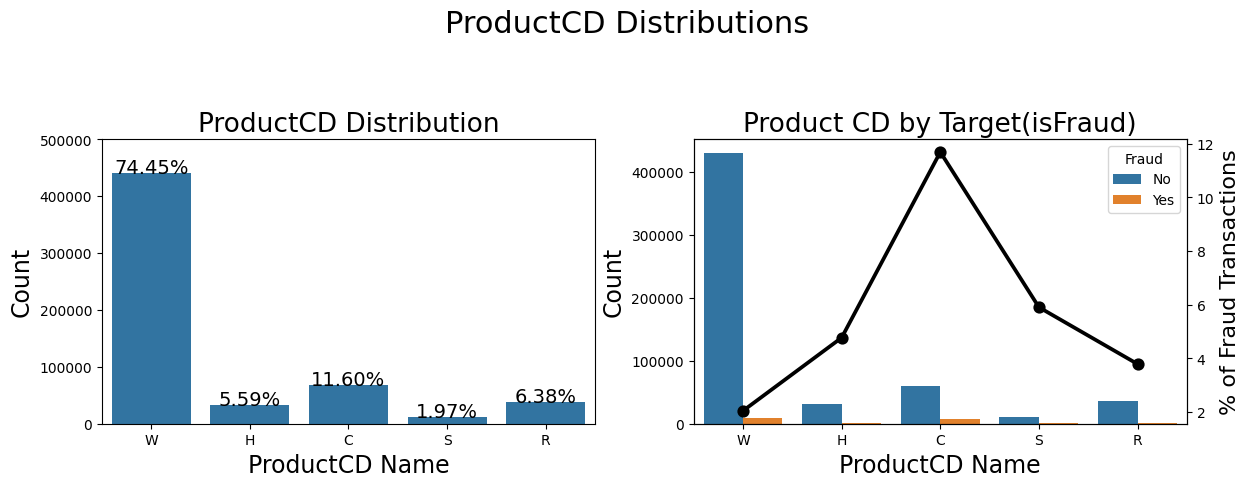

In [75]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

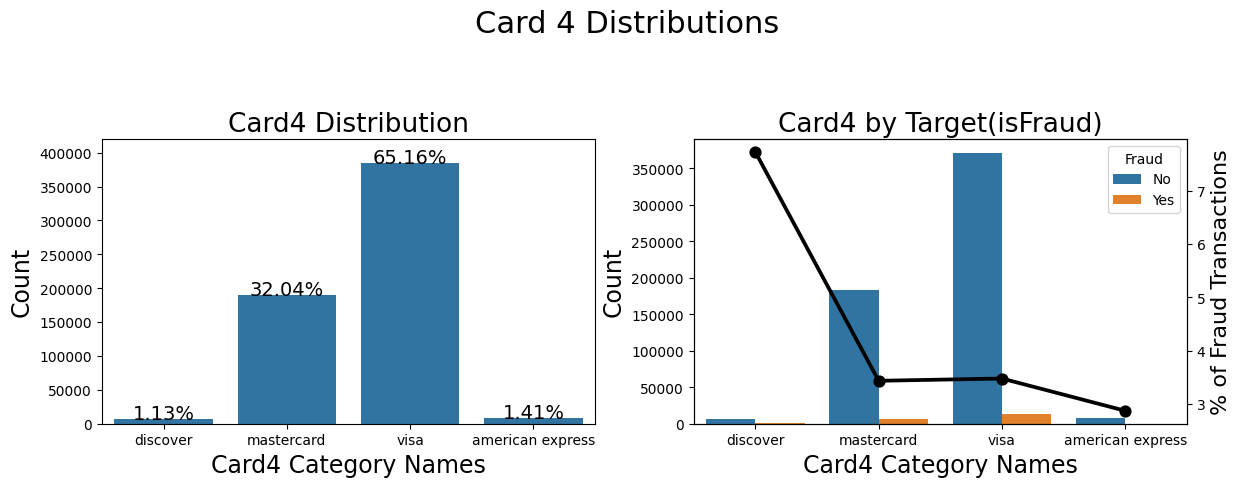

In [76]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

We can see that 97% of our data are in Mastercard(32%) and Visa(65%);

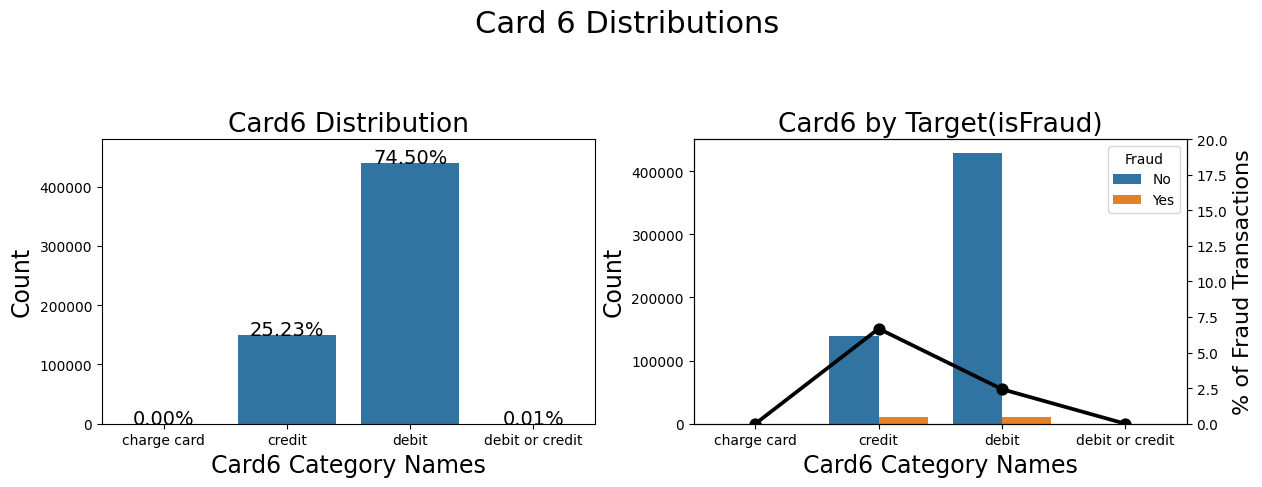

In [78]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

All data is on Credit and Debit. We can see a high percentual of Frauds in Credit than Debit transactions.

In [79]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [80]:
# Convert to string first
df_trans['addr1'] = df_trans['addr1'].astype(str)
df_trans['addr2'] = df_trans['addr2'].astype(str)

# Replace rare categories with "Others"
df_trans.loc[df_trans['addr1'].isin(df_trans['addr1'].value_counts()[df_trans['addr1'].value_counts() <= 5000].index), 'addr1'] = "Others"
df_trans.loc[df_trans['addr2'].isin(df_trans['addr2'].value_counts()[df_trans['addr2'].value_counts() <= 50].index), 'addr2'] = "Others"


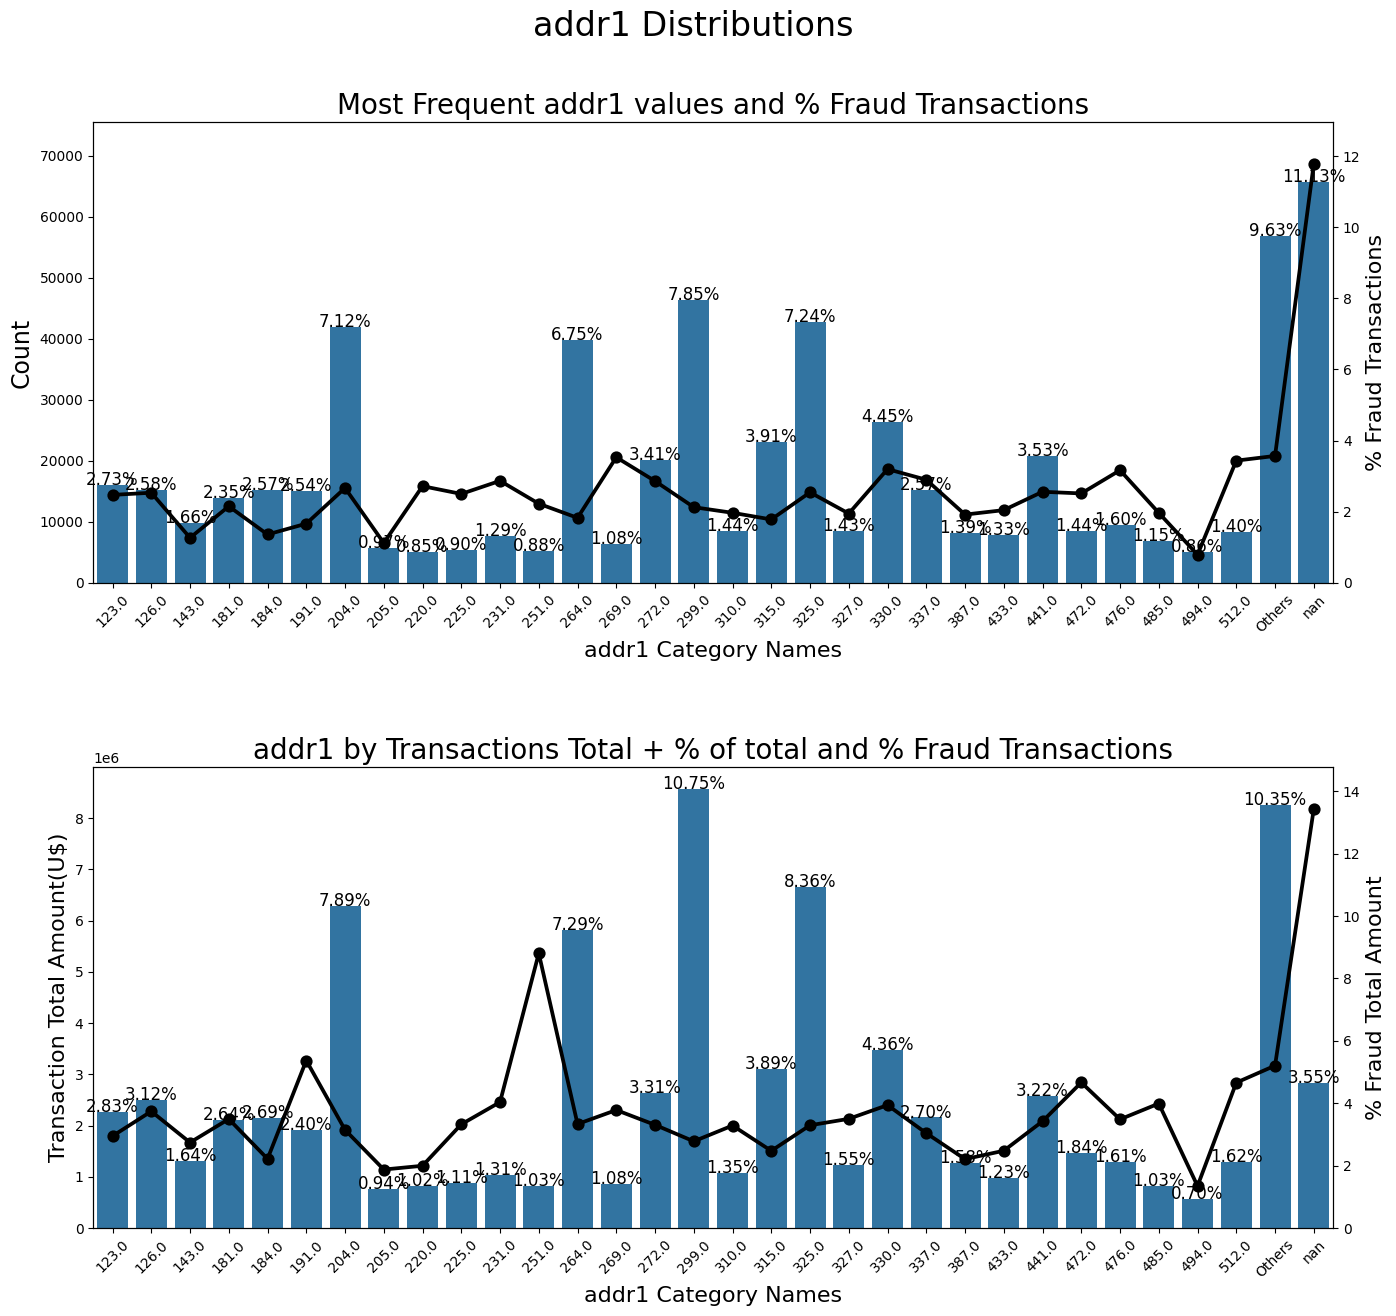

In [81]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    
    total = df[col].count()  # Define total
    total_amt = df['TransactionAmt'].sum()  # Define total transaction amount
    
    plt.figure(figsize=(16, 14))    
    plt.suptitle(f'{col} Distributions', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values), color='black', legend=False)
    gt.set_ylim(0, tmp['Fraud'].max() * 1.1)
    gt.set_ylabel("% Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    
    # Set x-ticks explicitly
    g.set_xticks(range(len(tmp[col].values)))
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x() + p.get_width() / 2., height + 3,
                '{:1.2f}%'.format(height / total * 100),
                ha="center", fontsize=12)

    g.set_ylim(0, max(sizes) * 1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud', col])['TransactionAmt'].sum() /
                 df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)

    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', data=amt, order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values), color='black', legend=False)
    g1t.set_ylim(0, perc_amt['Fraud'].max() * 1.1)
    g1t.set_ylabel("% Fraud Total Amount", fontsize=16)
    
    # Set x-ticks explicitly for the second subplot
    g1.set_xticks(range(len(tmp[col].values)))
    g1.set_xticklabels(g.get_xticklabels(), rotation=45)

    g1.set_title(f"{col} by Transactions Total + % of total and % Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x() + p.get_width() / 2., height + 3,
                 '{:1.2f}%'.format(height / total_amt * 100),
                 ha="center", fontsize=12)

    plt.subplots_adjust(hspace=.4, top=0.9)
    plt.show()

# Example usage
ploting_cnt_amt(df_trans, 'addr1')


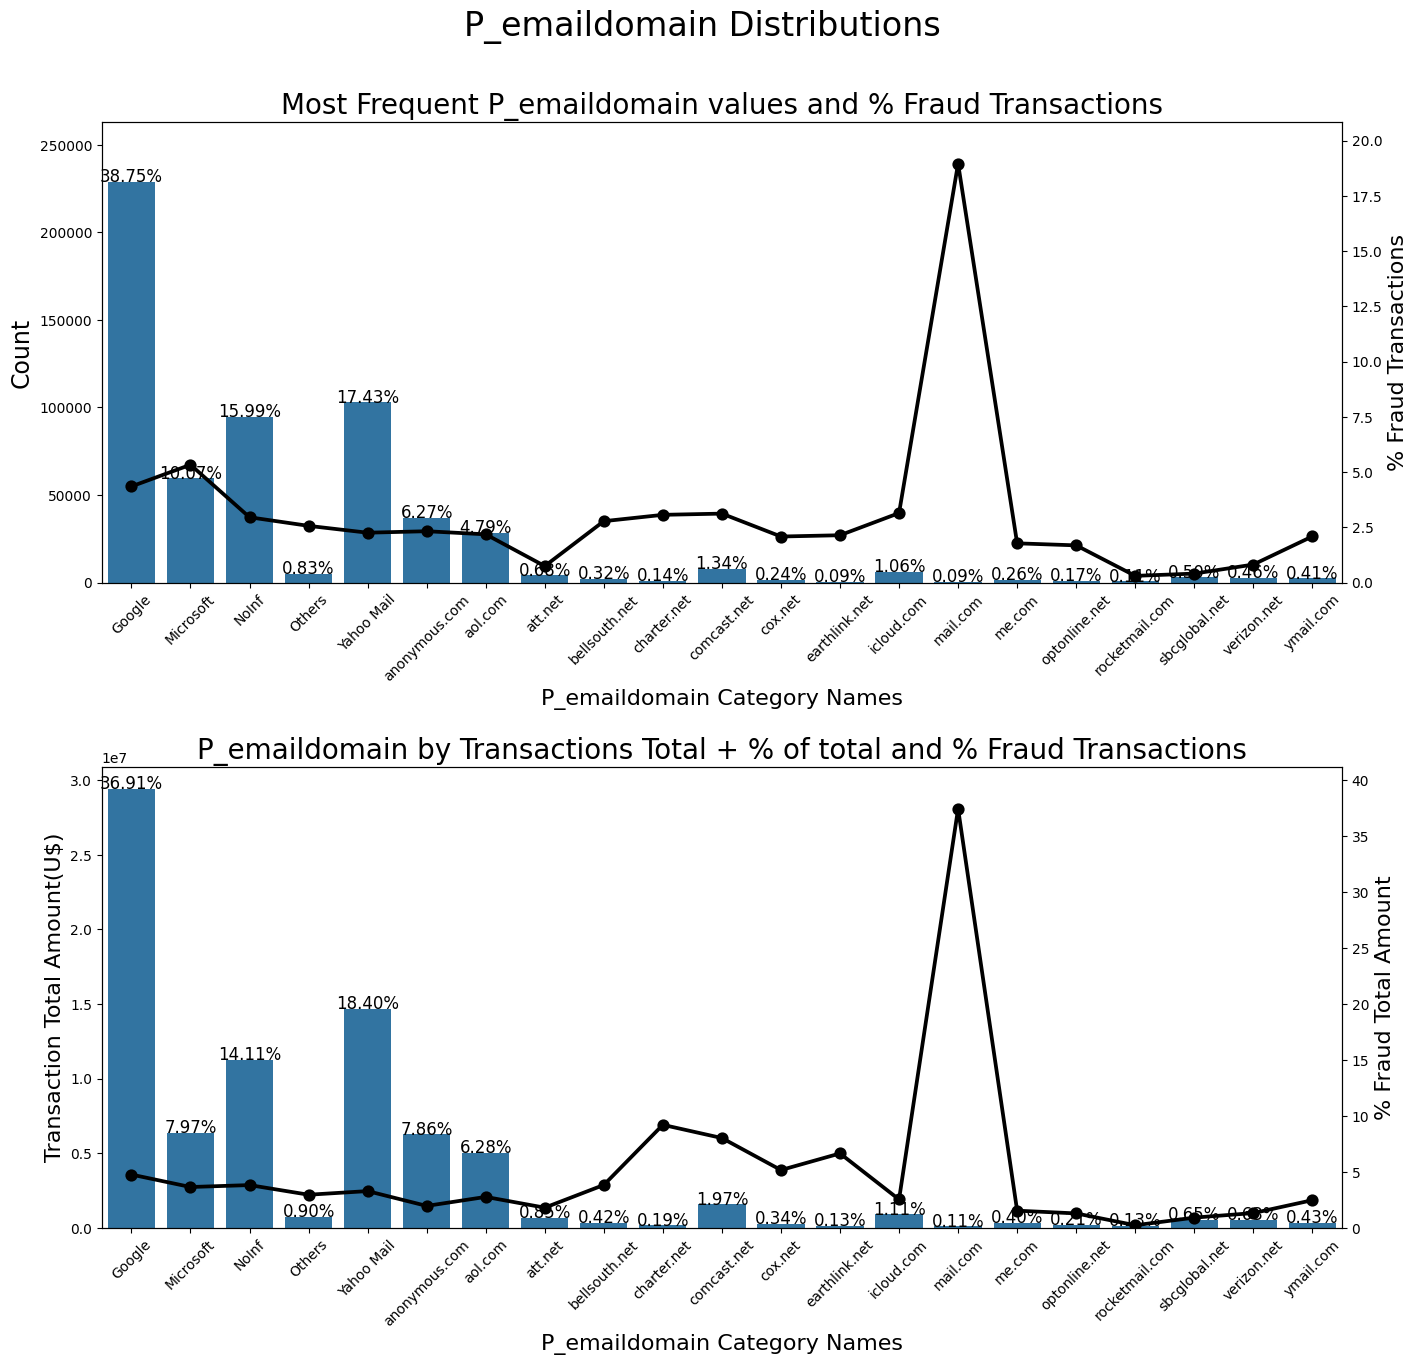

In [82]:
df_email = df_trans[['P_emaildomain', 'isFraud', 'TransactionAmt', 'R_emaildomain']].copy()

# Replace known email providers
df_email['P_emaildomain'] = df_email['P_emaildomain'].replace(
    ['gmail.com', 'gmail'], 'Google')

df_email['P_emaildomain'] = df_email['P_emaildomain'].replace(
    ['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 
     'yahoo.de', 'yahoo.fr', 'yahoo.es'], 'Yahoo Mail')

df_email['P_emaildomain'] = df_email['P_emaildomain'].replace(
    ['hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 
     'hotmail.es', 'hotmail.co.uk', 'hotmail.de',
     'outlook.es', 'live.com', 'live.fr', 'hotmail.fr'], 'Microsoft')

# Group low-frequency domains into "Others"
low_freq_domains = df_email['P_emaildomain'].value_counts()[df_email['P_emaildomain'].value_counts() <= 500].index
df_email.loc[df_email['P_emaildomain'].isin(low_freq_domains), 'P_emaildomain'] = "Others"

# Fill missing values
df_email['P_emaildomain'] = df_email['P_emaildomain'].fillna("NoInf")

ploting_cnt_amt(df_email, 'P_emaildomain')



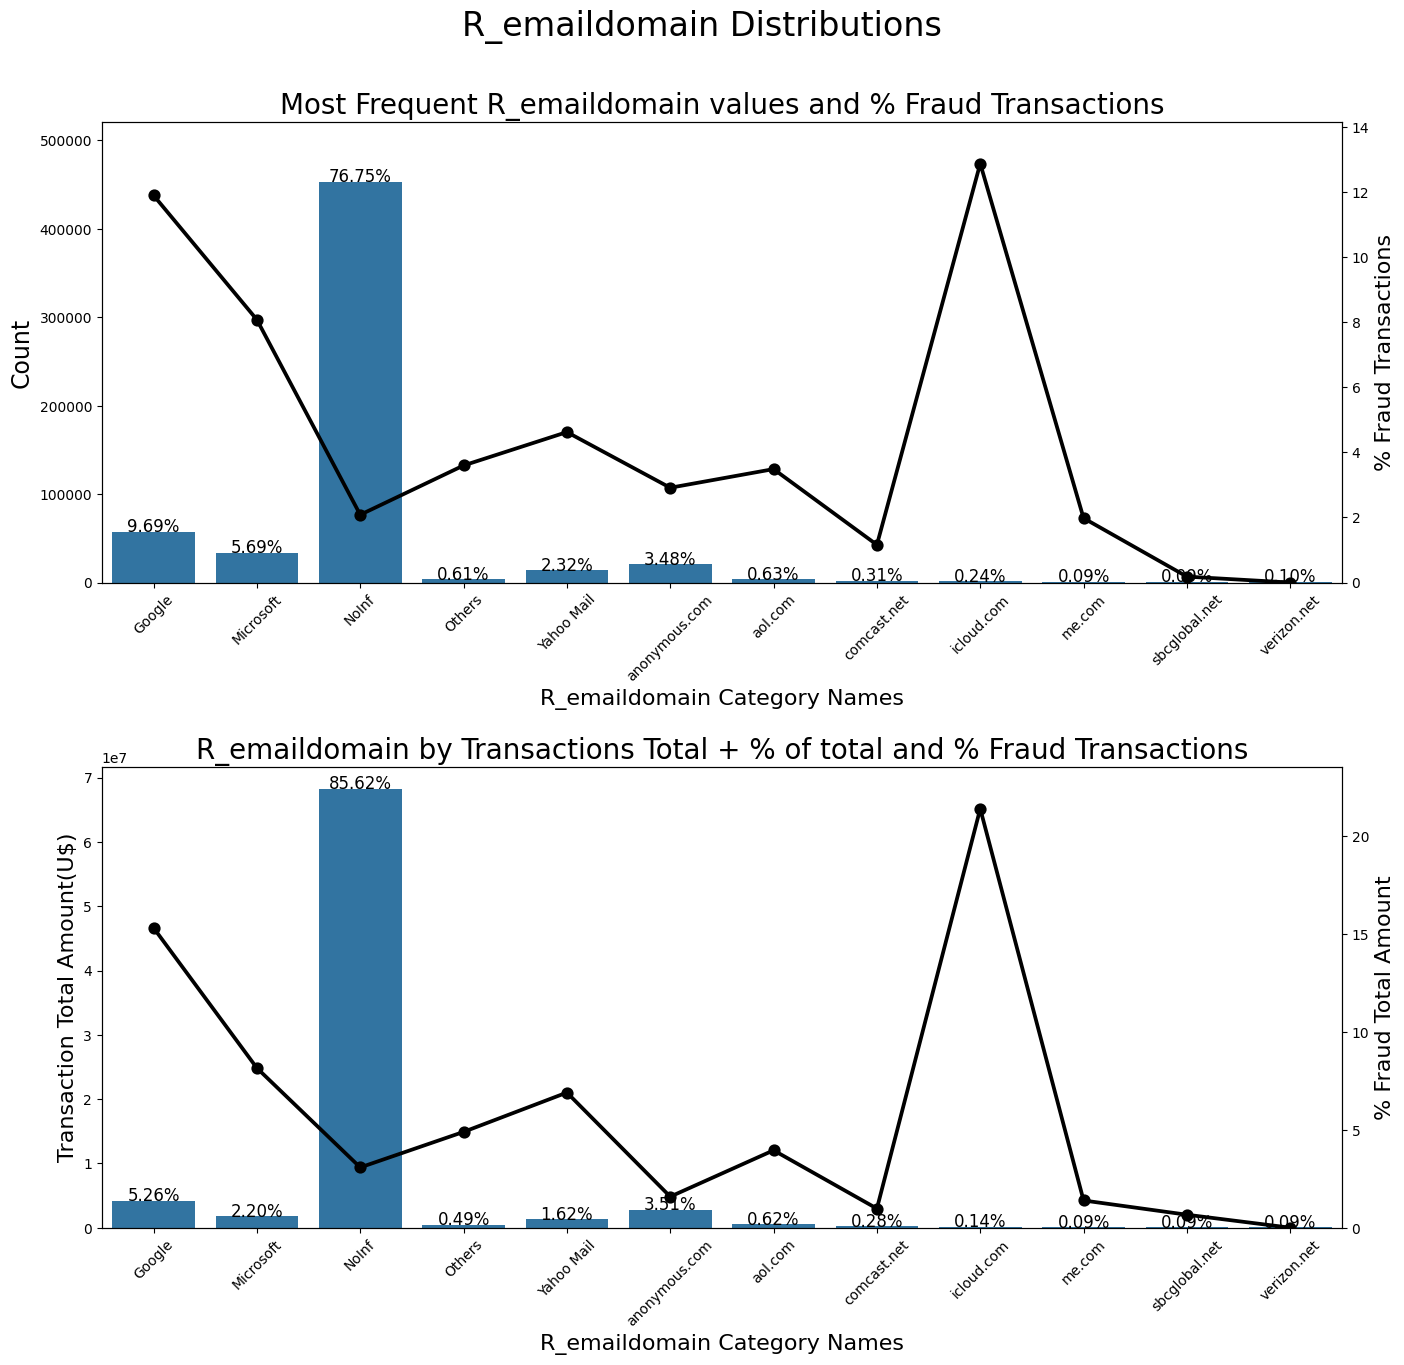

In [83]:
df_email = df_trans[['P_emaildomain', 'isFraud', 'TransactionAmt', 'R_emaildomain']].copy()

# Replace known email providers
df_email['R_emaildomain'] = df_email['R_emaildomain'].replace(
    ['gmail.com', 'gmail'], 'Google')

df_email['R_emaildomain'] = df_email['R_emaildomain'].replace(
    ['yahoo.com', 'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 
     'yahoo.de', 'yahoo.fr', 'yahoo.es'], 'Yahoo Mail')

df_email['R_emaildomain'] = df_email['R_emaildomain'].replace(
    ['hotmail.com', 'outlook.com', 'msn.com', 'live.com.mx', 
     'hotmail.es', 'hotmail.co.uk', 'hotmail.de',
     'outlook.es', 'live.com', 'live.fr', 'hotmail.fr'], 'Microsoft')

# Group low-frequency domains into "Others"
low_freq_domains = df_email['R_emaildomain'].value_counts()[df_email['R_emaildomain'].value_counts() <= 500].index
df_email.loc[df_email['R_emaildomain'].isin(low_freq_domains), 'R_emaildomain'] = "Others"

# Fill missing values
df_email['R_emaildomain'] = df_email['R_emaildomain'].fillna("NoInf")

ploting_cnt_amt(df_email, 'R_emaildomain')

In [84]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

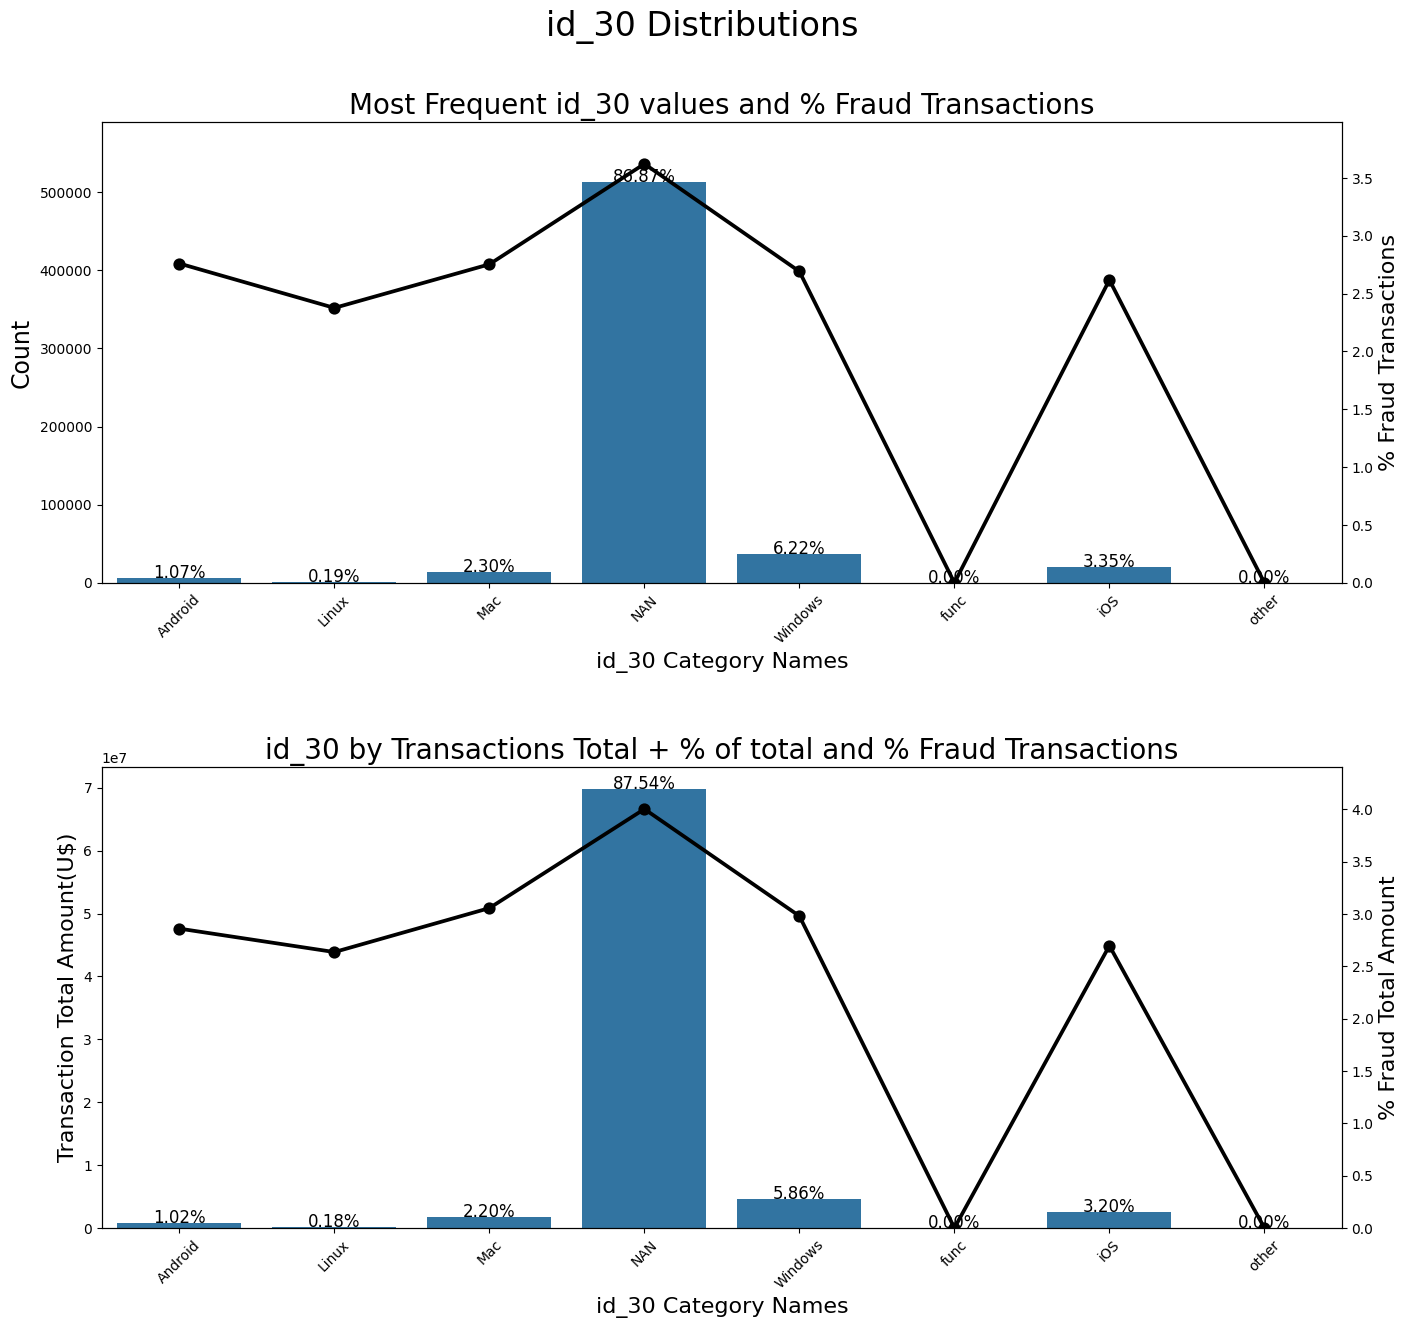

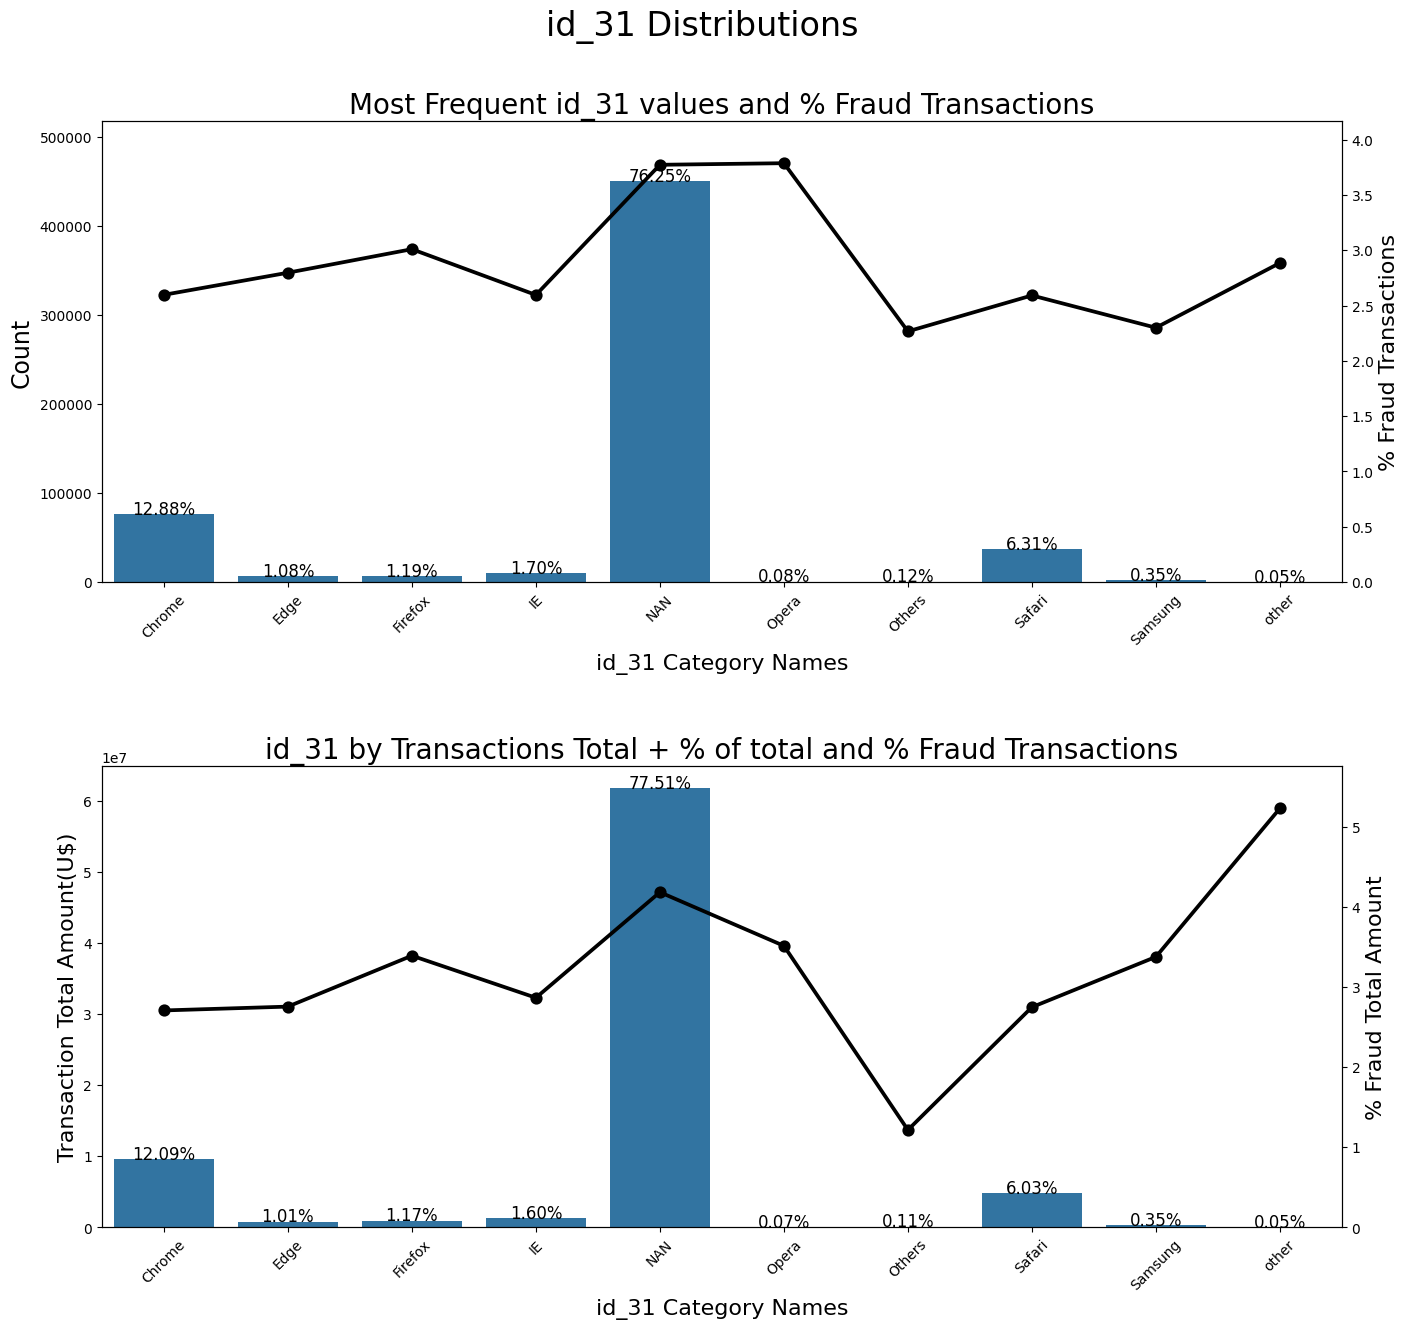

In [85]:
# Create a copy of the filtered columns
df_filteredCopy = df_train[['id_30', 'id_31', 'isFraud', 'TransactionAmt']].copy()

# Update id_30 values based on conditions
df_filteredCopy.loc[df_filteredCopy['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_filteredCopy.loc[df_filteredCopy['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_filteredCopy.loc[df_filteredCopy['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
df_filteredCopy.loc[df_filteredCopy['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'

# Fill NaN values in id_30 and assign back
df_filteredCopy['id_30'] = df_filteredCopy['id_30'].fillna("NAN")

# Update id_31 values based on conditions
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_filteredCopy.loc[df_filteredCopy['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'

# Fill NaN values in id_31 and assign back
df_filteredCopy['id_31'] = df_filteredCopy['id_31'].fillna("NAN")

# Group less frequent categories into "Others"
value_counts = df_filteredCopy['id_31'].value_counts()
df_filteredCopy.loc[df_filteredCopy['id_31'].isin(value_counts[value_counts < 200].index), 'id_31'] = "Others"

ploting_cnt_amt(df_filteredCopy, 'id_30')
ploting_cnt_amt(df_filteredCopy, 'id_31')
